In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Read the CSV file into a pandas DataFrame
dataset = pd.read_csv('goldstock.csv')

In [3]:
# Convert 'Date' column to datetime format and set as index
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)

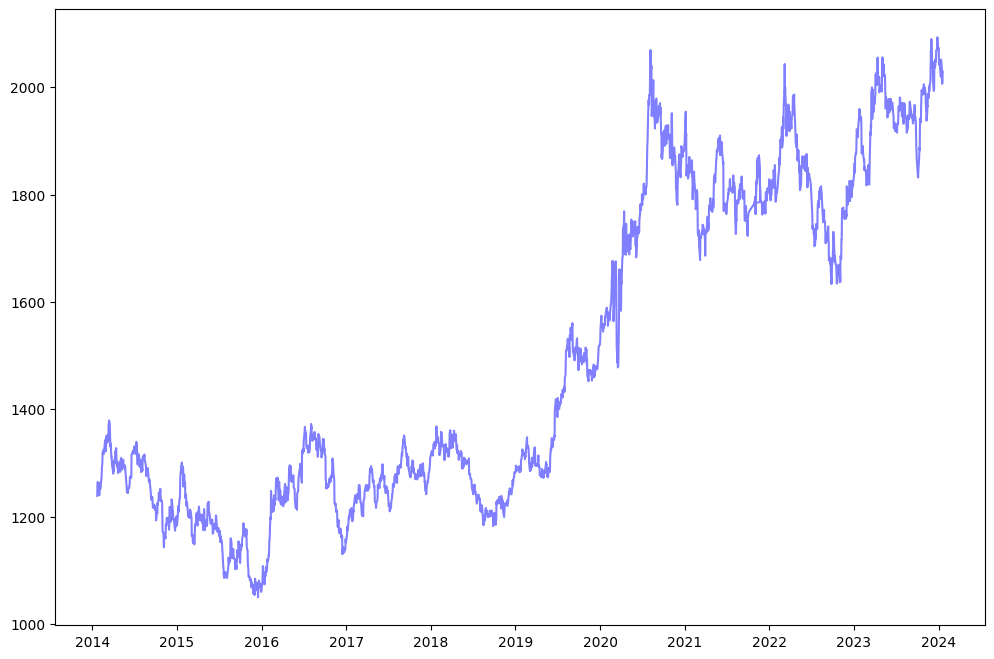

In [4]:
# Calculate and visualize different moving averages
window_sizes = [30, 90, 180]  # Short-term, medium-term, and long-term moving averages

plt.figure(figsize=(12, 8))
plt.plot(dataset['Close'], label='Gold Price', color='blue', alpha=0.5)

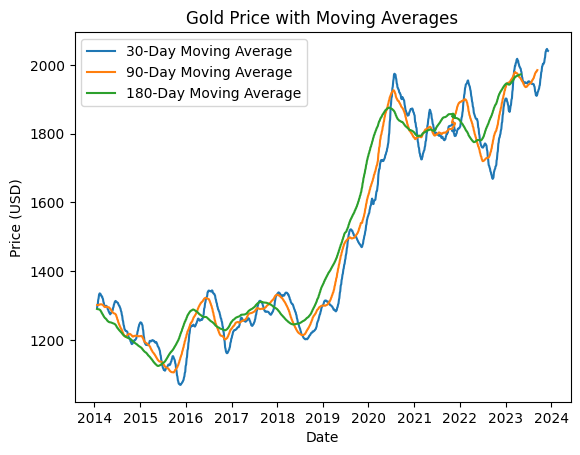

In [5]:
for window in window_sizes:
    rolling_mean = dataset['Close'].rolling(window=window).mean()
    plt.plot(rolling_mean, label=f'{window}-Day Moving Average')

plt.title('Gold Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

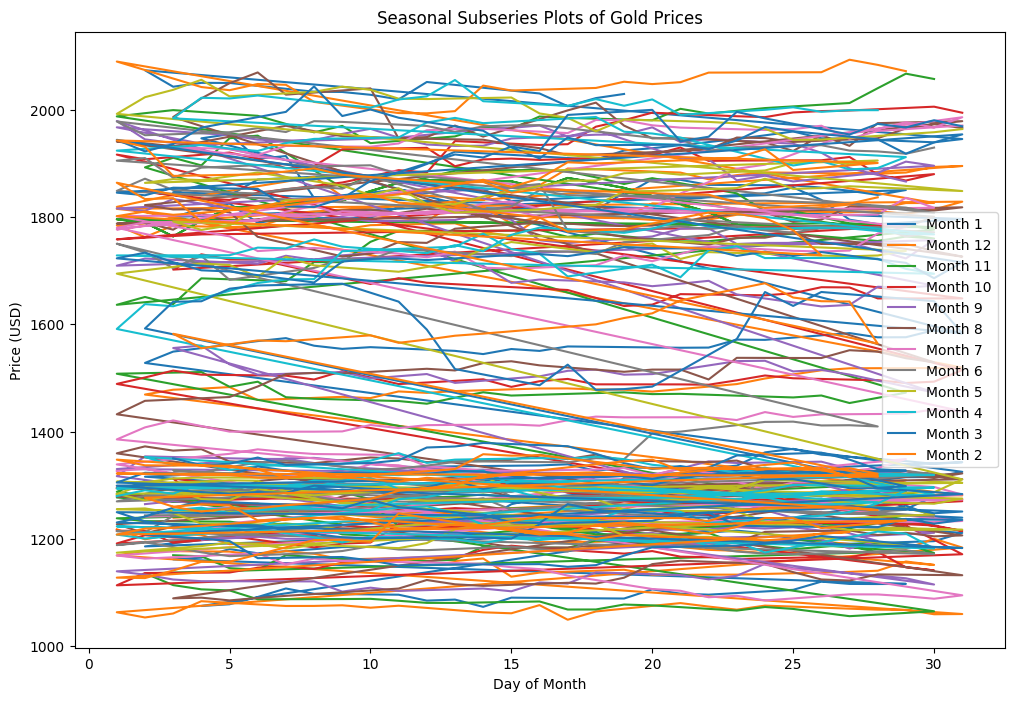

In [6]:
# Seasonal Subseries Plots
seasons = dataset.index.month.unique()

plt.figure(figsize=(12, 8))
for season in seasons:
    subset = dataset[dataset.index.month == season]
    plt.plot(subset.index.day, subset['Close'], label=f'Month {season}')

plt.title('Seasonal Subseries Plots of Gold Prices')
plt.xlabel('Day of Month')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

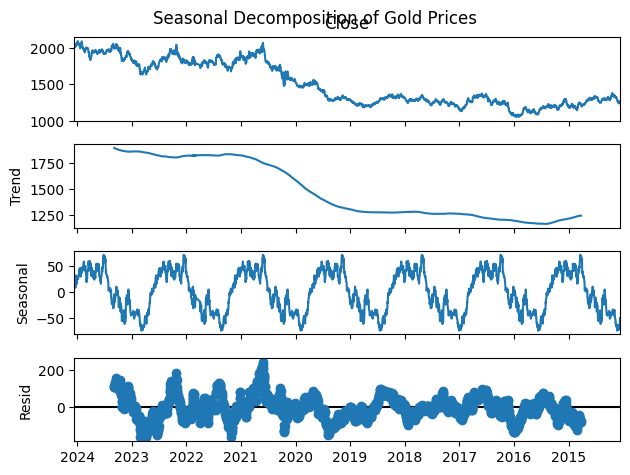

In [7]:
# Seasonal Decomposition
decomposition = seasonal_decompose(dataset['Close'], model='additive', period=365)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Gold Prices')
plt.show()

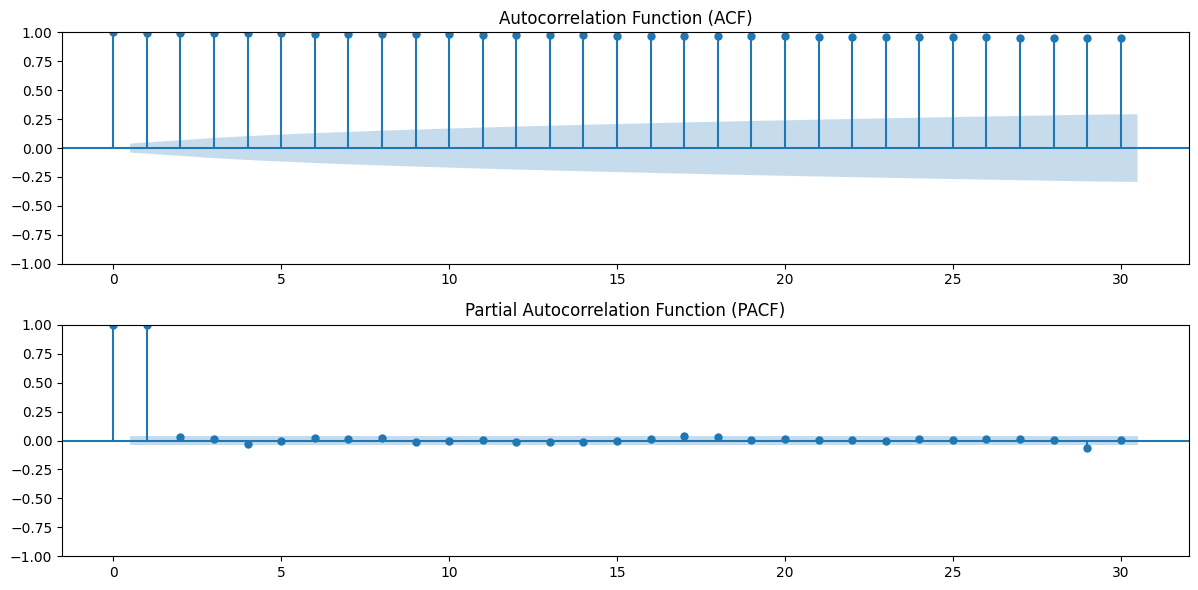

In [8]:
# Autocorrelation and Partial Autocorrelation Functions
plt.figure(figsize=(12, 6))
plot_acf(dataset['Close'], lags=30, ax=plt.subplot(211))
plt.title('Autocorrelation Function (ACF)')
plot_pacf(dataset['Close'], lags=30, ax=plt.subplot(212))
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [10]:
# Ensure the date index is sorted
dataset.sort_index(inplace=True)

In [11]:
# Preprocessing:
# Handle missing values (if any)
dataset.dropna(inplace=True)

In [12]:
# Split the data into training and testing sets
train_size = int(len(dataset) * 0.8)
train_data, test_data = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [13]:
# Model Training and Evaluation:
def evaluate_model(model, train_data, test_data):
    # Fit the model
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.forecast(steps=len(test_data))

    # Calculate evaluation metrics
    rmse = sqrt(mean_squared_error(test_data, predictions))
    mae = mean_absolute_error(test_data, predictions)

    return predictions, rmse, mae

In [14]:
# ARIMA Model
arima_model = ARIMA(train_data['Close'], order=(5,1,0))
arima_predictions, arima_rmse, arima_mae = evaluate_model(arima_model, train_data['Close'], test_data['Close'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [15]:
# Holt-Winters Exponential Smoothing Model
hw_model = ExponentialSmoothing(train_data['Close'], trend='add', seasonal='add', seasonal_periods=12)
hw_predictions, hw_rmse, hw_mae = evaluate_model(hw_model, train_data['Close'], test_data['Close'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


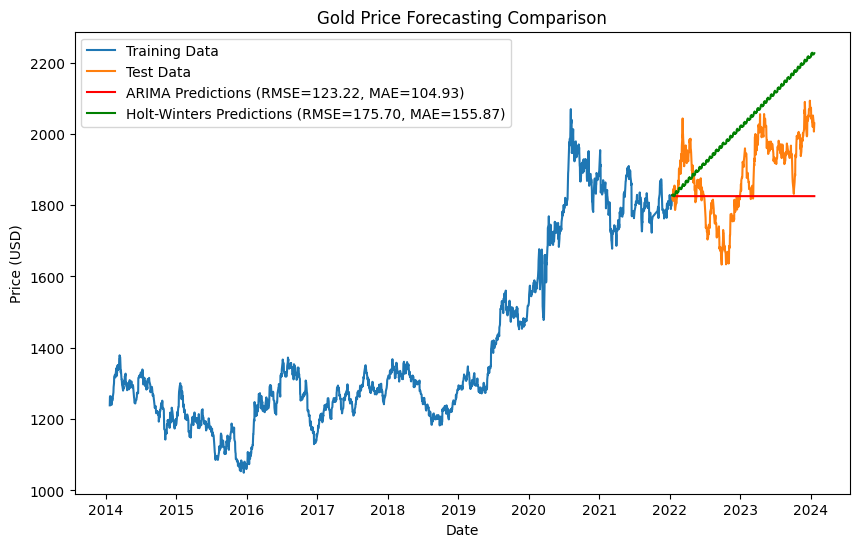

In [16]:
# Visualize actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Close'], label='Training Data')
plt.plot(test_data.index, test_data['Close'], label='Test Data')
plt.plot(test_data.index, arima_predictions, label=f'ARIMA Predictions (RMSE={arima_rmse:.2f}, MAE={arima_mae:.2f})', color='red')
plt.plot(test_data.index, hw_predictions, label=f'Holt-Winters Predictions (RMSE={hw_rmse:.2f}, MAE={hw_mae:.2f})', color='green')
plt.title('Gold Price Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [17]:
# Ensure the date index is sorted
dataset.sort_index(inplace=True)

In [18]:
# Preprocessing:
# Handle missing values (if any)
dataset.dropna(inplace=True)

In [19]:
# Define parameters for the trading strategy
short_window = 50  # Short-term moving average window
long_window = 200  # Long-term moving average window

In [20]:
# Compute moving averages
dataset['Short_MA'] = dataset['Close'].rolling(window=short_window, min_periods=1).mean()
dataset['Long_MA'] = dataset['Close'].rolling(window=long_window, min_periods=1).mean()

In [21]:
# Generate conventional trading signals (based on moving averages crossover)
dataset['Conventional_Signal'] = 0  # 0: No action, 1: Buy, -1: Sell
dataset['Conventional_Signal'][short_window:] = np.where(dataset['Short_MA'][short_window:] > dataset['Long_MA'][short_window:], 1, 0)
dataset['Conventional_Signal'][short_window:] = np.where(dataset['Short_MA'][short_window:] < dataset['Long_MA'][short_window:], -1, 0)

<ipython-input-21-5ff5be9fcd67>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Conventional_Signal'][short_window:] = np.where(dataset['Short_MA'][short_window:] > dataset['Long_MA'][short_window:], 1, 0)
<ipython-input-21-5ff5be9fcd67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Conventional_Signal'][short_window:] = np.where(dataset['Short_MA'][short_window:] < dataset['Long_MA'][short_window:], -1, 0)


In [22]:
# Calculate daily returns based on the conventional trading signals
dataset['Daily_Returns'] = dataset['Close'].pct_change()  # Daily percentage change in prices
dataset['Conventional_Strategy_Returns'] = dataset['Daily_Returns'] * dataset['Conventional_Signal'].shift(1)  # Strategy returns

In [23]:
# Calculate cumulative returns for conventional strategy
dataset['Conventional_Cumulative_Returns'] = (1 + dataset['Conventional_Strategy_Returns']).cumprod() - 1

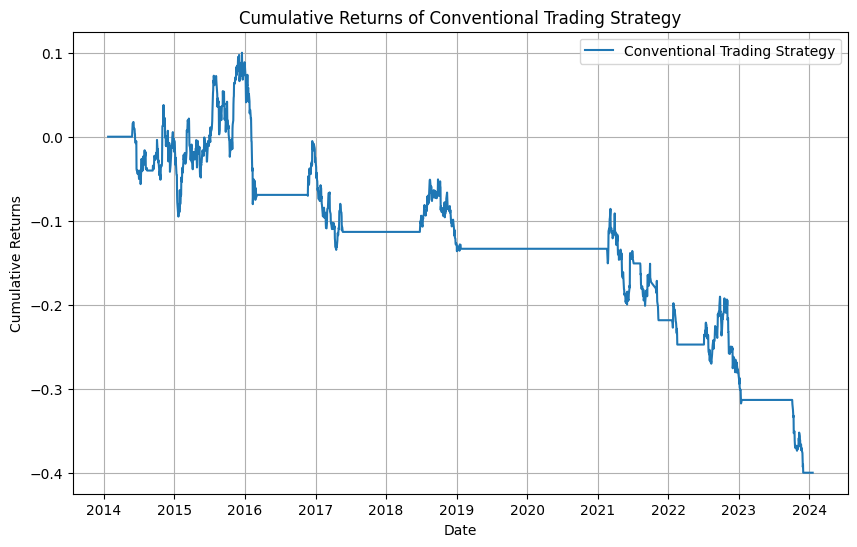

In [24]:
# Plot cumulative returns for conventional strategy
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['Conventional_Cumulative_Returns'], label='Conventional Trading Strategy')
plt.title('Cumulative Returns of Conventional Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Explore reverse trading strategies:
# For example, a reverse strategy could involve buying when the price is falling and selling when the price is rising.

# Generate reverse trading signals
dataset['Reverse_Signal'] = -dataset['Conventional_Signal']  # Inverse of conventional signals

In [26]:
# Calculate daily returns based on the reverse trading signals
dataset['Reverse_Strategy_Returns'] = dataset['Daily_Returns'] * dataset['Reverse_Signal'].shift(1)  # Strategy returns

In [27]:
# Calculate cumulative returns for reverse strategy
dataset['Reverse_Cumulative_Returns'] = (1 + dataset['Reverse_Strategy_Returns']).cumprod() - 1

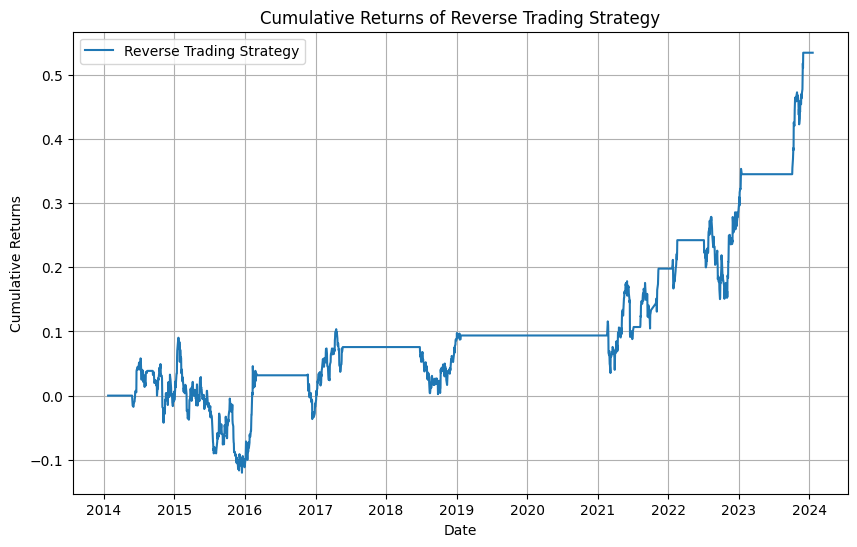

In [28]:
# Plot cumulative returns for reverse strategy
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['Reverse_Cumulative_Returns'], label='Reverse Trading Strategy')
plt.title('Cumulative Returns of Reverse Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Define parameters for the trading strategy
short_window = 50  # Short-term moving average window
long_window = 200  # Long-term moving average window

In [30]:
# Compute moving averages
dataset['Short_MA'] = dataset['Close'].rolling(window=short_window, min_periods=1).mean()
dataset['Long_MA'] = dataset['Close'].rolling(window=long_window, min_periods=1).mean()

In [31]:
# Generate trading signals for trend-following strategy
dataset['Signal_Trend'] = 0  # 0: No action, 1: Buy, -1: Sell
dataset['Signal_Trend'][short_window:] = np.where(dataset['Short_MA'][short_window:] > dataset['Long_MA'][short_window:], 1, 0)
dataset['Signal_Trend'][short_window:] = np.where(dataset['Short_MA'][short_window:] < dataset['Long_MA'][short_window:], -1, 0)

<ipython-input-31-5f334584bac7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Signal_Trend'][short_window:] = np.where(dataset['Short_MA'][short_window:] > dataset['Long_MA'][short_window:], 1, 0)
<ipython-input-31-5f334584bac7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Signal_Trend'][short_window:] = np.where(dataset['Short_MA'][short_window:] < dataset['Long_MA'][short_window:], -1, 0)


In [32]:
# Calculate daily returns based on the trend-following strategy
dataset['Daily_Returns'] = dataset['Close'].pct_change()  # Daily percentage change in prices
dataset['Strategy_Returns_Trend'] = dataset['Daily_Returns'] * dataset['Signal_Trend'].shift(1)  # Strategy returns


In [33]:
# Calculate cumulative returns for trend-following strategy
dataset['Cumulative_Returns_Trend'] = (1 + dataset['Strategy_Returns_Trend']).cumprod() - 1

In [34]:
# Implement Reverse Trading Strategies
# Mean Reversion Strategy
threshold_percentage = 0.1  # Example threshold percentage
mean_price = dataset['Close'].mean()
dataset['Signal_Mean_Reversion'] = np.where(dataset['Close'] < mean_price * (1 - threshold_percentage), 1, 0)
dataset['Signal_Mean_Reversion'] = np.where(dataset['Close'] > mean_price * (1 + threshold_percentage), -1, dataset['Signal_Mean_Reversion'])

In [35]:
# Contrarian Strategy
consecutive_days = 3  # Example number of consecutive days
dataset['Price_Change'] = dataset['Close'].diff()
dataset['Signal_Contrarian'] = 0
for i in range(len(dataset)):
    if i >= consecutive_days:
        if all(dataset['Price_Change'][i-j] < 0 for j in range(1, consecutive_days+1)):
            dataset['Signal_Contrarian'][i] = 1  # Buy signal
        elif all(dataset['Price_Change'][i-j] > 0 for j in range(1, consecutive_days+1)):
            dataset['Signal_Contrarian'][i] = -1  # Sell signal

<ipython-input-35-3d7a9d3715ec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Signal_Contrarian'][i] = -1  # Sell signal
<ipython-input-35-3d7a9d3715ec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Signal_Contrarian'][i] = -1  # Sell signal
<ipython-input-35-3d7a9d3715ec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Signal_Contrarian'][i] = -1  # Sell signal
<ipython-input-35-3d7a9d3715ec>:10: S

In [36]:
# Backtesting and Evaluation of Other Strategies
# Mean Reversion Strategy
dataset['Strategy_Returns_Mean_Reversion'] = dataset['Daily_Returns'] * dataset['Signal_Mean_Reversion'].shift(1)
dataset['Cumulative_Returns_Mean_Reversion'] = (1 + dataset['Strategy_Returns_Mean_Reversion']).cumprod() - 1

In [37]:
# Contrarian Strategy
dataset['Strategy_Returns_Contrarian'] = dataset['Daily_Returns'] * dataset['Signal_Contrarian'].shift(1)
dataset['Cumulative_Returns_Contrarian'] = (1 + dataset['Strategy_Returns_Contrarian']).cumprod() - 1

In [38]:
# Analysis and Comparison of All Strategies
# Calculate relevant performance metrics for each strategy
metrics = ['Cumulative_Returns_Trend', 'Cumulative_Returns_Mean_Reversion', 'Cumulative_Returns_Contrarian']
strategy_names = ['Trend-Following', 'Mean Reversion', 'Contrarian']

for i, metric in enumerate(metrics):
    cumulative_returns = dataset[metric][-1]
    # Calculate other performance metrics (Sharpe ratio, maximum drawdown, etc.) if needed
    print(f"{strategy_names[i]} Strategy:")
    print(f"Cumulative Returns: {cumulative_returns:.2f}")
    print()

Trend-Following Strategy:
Cumulative Returns: -0.40

Mean Reversion Strategy:
Cumulative Returns: 0.14

Contrarian Strategy:
Cumulative Returns: -0.41



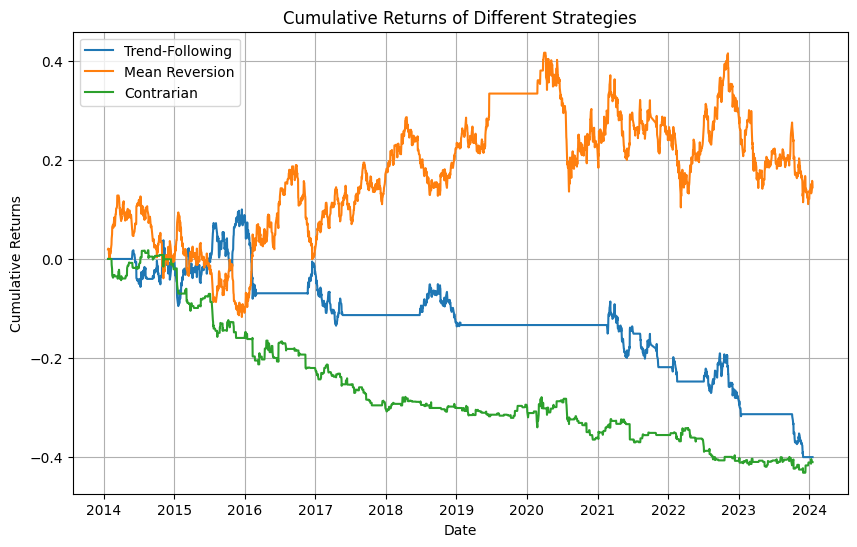

In [39]:
# Plot cumulative returns for all strategies
plt.figure(figsize=(10, 6))
for metric, name in zip(metrics, strategy_names):
    plt.plot(dataset.index, dataset[metric], label=name)
plt.title('Cumulative Returns of Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

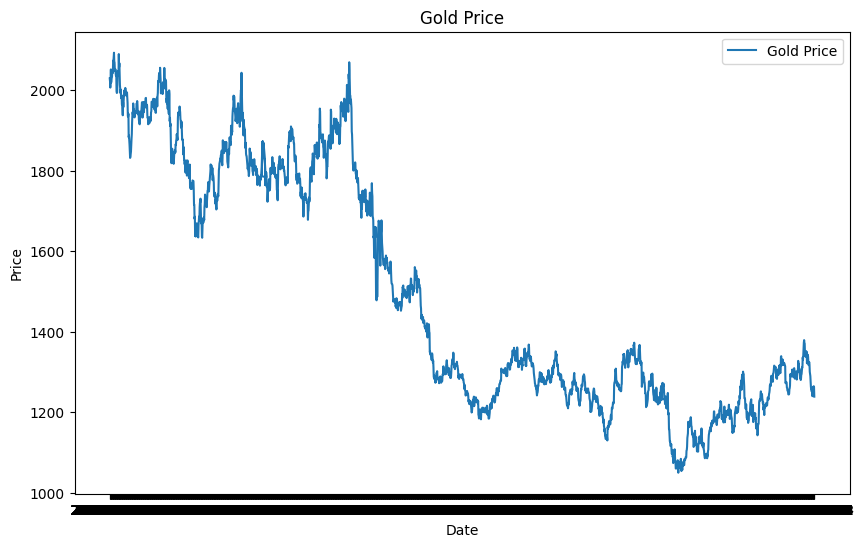

In [41]:
# Read gold price data
gold_prices = pd.read_csv('goldstock.csv')

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(gold_prices['Date'], gold_prices['Close'], label='Gold Price')
plt.title('Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [42]:
# Statistical Analysis
# Simple linear regression to assess the impact of sentiment on gold prices
X = np.arange(len(gold_prices)).reshape(-1, 1)
y = gold_prices['Close'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)
print("Mean Squared Error:", mse)
print("Coefficient:", model.coef_[0][0])


Mean Squared Error: 18464.082028068467
Coefficient: -0.3670711202780746


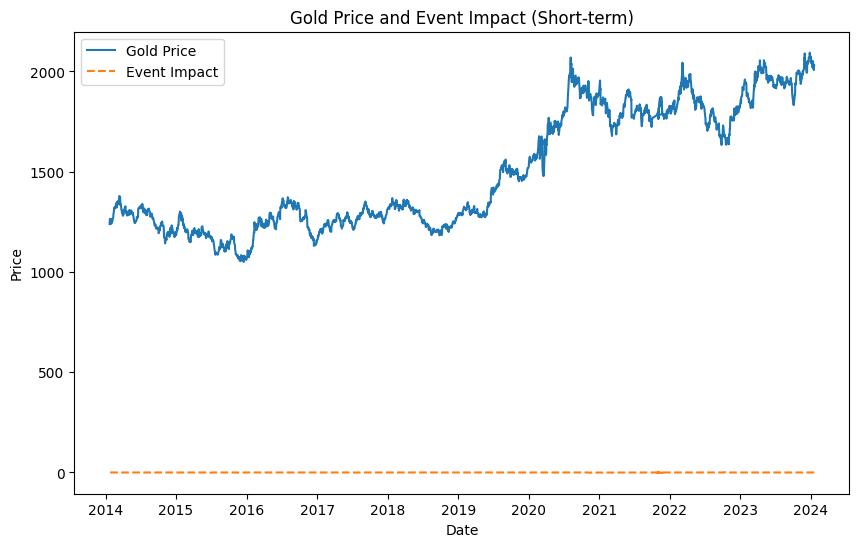

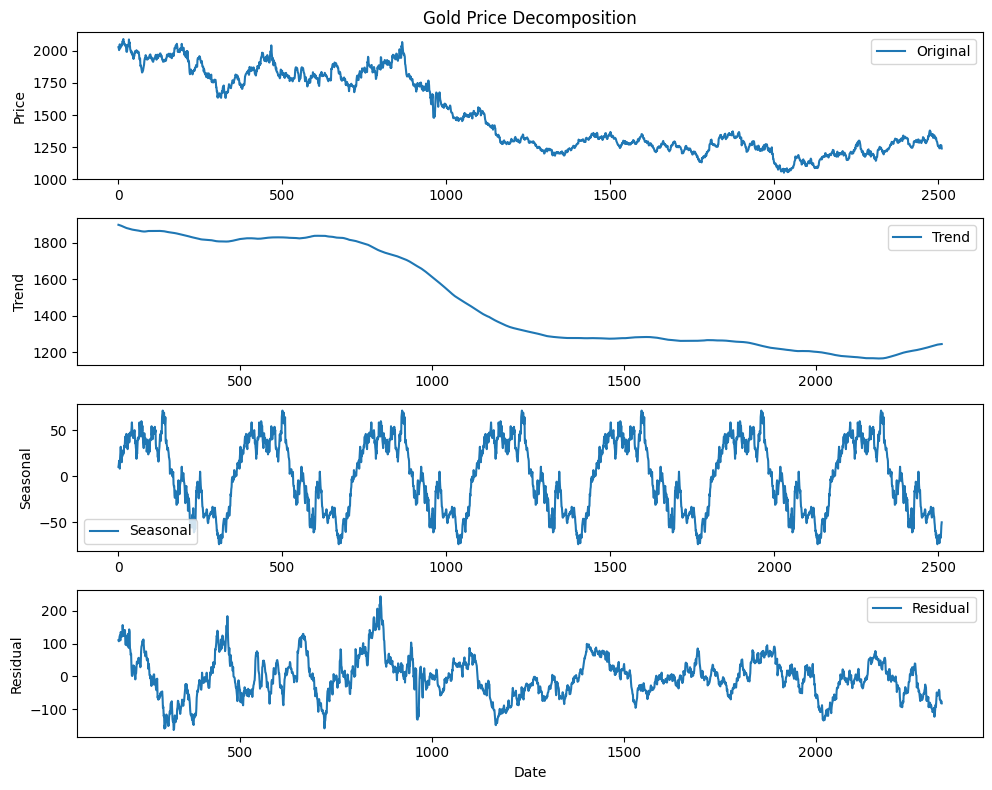

Mean Squared Error: 88850.51157325432
Coefficient: 154.83814397729276


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob  # For sentiment analysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Read gold price data
gold_prices = pd.read_csv('goldstock.csv')
gold_prices['Date'] = pd.to_datetime(gold_prices['Date'])
gold_prices.set_index('Date', inplace=True)

# Generate synthetic market events data for demonstration
num_events = 20
np.random.seed(0)
event_dates = np.random.choice(gold_prices.index, num_events, replace=False)
event_sentiments = np.random.uniform(-1, 1, num_events)
market_events = pd.DataFrame({'Date': event_dates, 'Sentiment': event_sentiments})

# Reset index of gold_prices
gold_prices.reset_index(inplace=True)

# Event analysis
# Identify significant market events and correlate with price movements
# For simplicity, let's assume the impact of events lasts for a certain number of days
impact_days = 5  # Adjust as needed

gold_prices['Event_Impact'] = 0
for _, row in market_events.iterrows():
    event_date = row['Date']
    start_index = gold_prices['Date'].sub(event_date).abs().idxmin()
    end_index = min(start_index + impact_days, len(gold_prices))
    gold_prices.loc[start_index:end_index, 'Event_Impact'] += row['Sentiment']

# Visualize and analyze short-term and long-term price movements
# Short-term analysis: Plot sentiment scores over time alongside gold price movements
plt.figure(figsize=(10, 6))
plt.plot(gold_prices['Date'], gold_prices['Close'], label='Gold Price')
plt.plot(gold_prices['Date'], gold_prices['Event_Impact'], label='Event Impact', linestyle='--')
plt.title('Gold Price and Event Impact (Short-term)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Long-term analysis: Decompose gold prices into trend, seasonality, and residual components
gold_prices.index.freq = 'D'  # Set frequency to daily
decomposition = seasonal_decompose(gold_prices['Close'], model='additive', period=365)  # Assuming yearly seasonality
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 8))

# Plot original gold prices
plt.subplot(4, 1, 1)
plt.plot(gold_prices.index, gold_prices['Close'], label='Original')
plt.title('Gold Price Decomposition')
plt.ylabel('Price')
plt.legend()

# Plot trend component
plt.subplot(4, 1, 2)
plt.plot(gold_prices.index, trend, label='Trend')
plt.ylabel('Trend')
plt.legend()

# Plot seasonal component
plt.subplot(4, 1, 3)
plt.plot(gold_prices.index, seasonal, label='Seasonal')
plt.ylabel('Seasonal')
plt.legend()

# Plot residual component
plt.subplot(4, 1, 4)
plt.plot(gold_prices.index, residual, label='Residual')
plt.ylabel('Residual')
plt.xlabel('Date')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical Analysis
# Simple linear regression to assess the impact of sentiment on gold prices
X = gold_prices['Event_Impact'].values.reshape(-1, 1)
y = gold_prices['Close'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
mse = mean_squared_error(y, predictions)
print("Mean Squared Error:", mse)
print("Coefficient:", model.coef_[0][0])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 13.5 MB/s eta 0:00:00
Descriptive Statistics of Gold Prices:
count    2511.000000
mean     1498.726085
std       298.824811
min      1049.600000
25%      1249.850000
50%      1332.800000
75%      1805.850000
max      2093.100000
Name: Close, dtype: float64

ADF Test Results:
ADF Statistic: -1.7172755789704768
P-value: 0.4222342775667287
Critical Values:
	1%: -3.4329579682301254
	5%: -2.8626921885291017
	10%: -2.5673833542324727


<Figure size 1000x600 with 0 Axes>

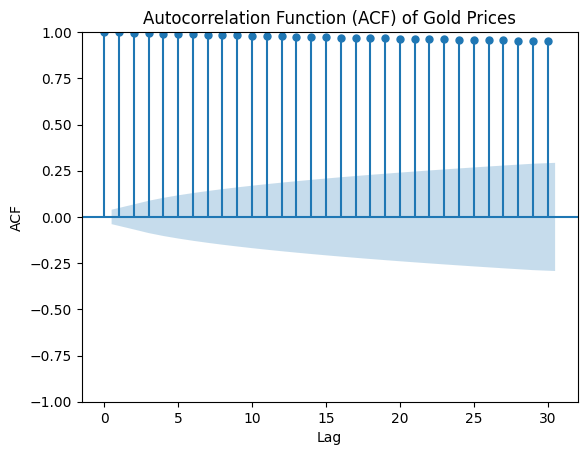

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.926e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 74488.91876127632
Iteration:      2,   Func. Count:     13,   Neg. LLF: 17286.20517465313
Iteration:      3,   Func. Count:     18,   Neg. LLF: 20802.214995845734
Iteration:      4,   Func. Count:     24,   Neg. LLF: 16832.730774454438
Iteration:      5,   Func. Count:     30,   Neg. LLF: 16103.499991143382
Iteration:      6,   Func. Count:     35,   Neg. LLF: 16100.709302668321
Iteration:      7,   Func. Count:     40,   Neg. LLF: 16098.672593772848
Iteration:      8,   Func. Count:     45,   Neg. LLF: 16098.389061459053
Iteration:      9,   Func. Count:     50,   Neg. LLF: 16098.332467786127
Iteration:     10,   Func. Count:     55,   Neg. LLF: 16098.31094214348
Iteration:     11,   Func. Count:     60,   Neg. LLF: 16098.168763452839
Iteration:     12,   Func. Count:     65,   Neg. LLF: 16097.356906636825
Iteration:     13,   Func. Count:     70,   Neg. LLF: 16092.965786664294
Iteration:     14,   Func. Count:     75,   Neg. LLF: 

<Figure size 1000x600 with 0 Axes>

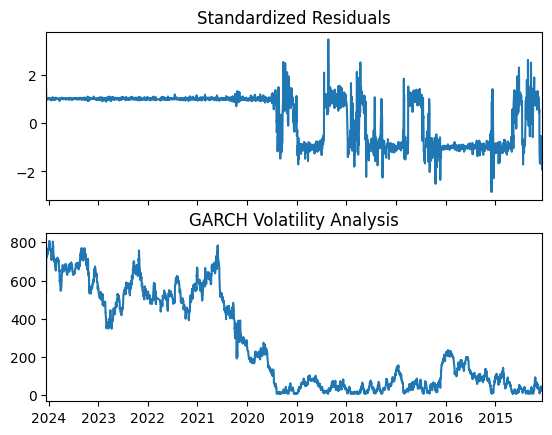

In [ ]:
!pip install arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

# Read gold price data
gold_prices = pd.read_csv('goldstock.csv')
gold_prices['Date'] = pd.to_datetime(gold_prices['Date'])
gold_prices.set_index('Date', inplace=True)

# Statistical Tests and Analyses
# Descriptive statistics
descriptive_stats = gold_prices['Close'].describe()
print("Descriptive Statistics of Gold Prices:")
print(descriptive_stats)
print()

# Stationarity test (ADF test)
adf_result = adfuller(gold_prices['Close'])
print("ADF Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value}")

# Autocorrelation analysis
plt.figure(figsize=(10, 6))
plot_acf(gold_prices['Close'], lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of Gold Prices')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Volatility analysis (GARCH model)
garch_model = arch_model(gold_prices['Close'], vol='GARCH', p=1, q=1)
garch_model_fit = garch_model.fit()
print("GARCH Model Summary:")
print(garch_model_fit.summary())

# Plotting volatility
plt.figure(figsize=(10, 6))
garch_model_fit.plot()
plt.title('GARCH Volatility Analysis')
plt.show()
